## <font color='#90c149'>Imports</font>

In [1]:
#Native imports
import os

In [2]:
#Library imports
import rasterio
import matplotlib.pyplot as plt
import numpy as np

## <font color='#90c149'>Setup</font>
We use images from the flair dataset. They are in TIF format and are composed of 5 channels.
- R
- G
- B
- NIR
- Elevation

In [3]:
# The relative path of the image being treated
tif_path = "../flair/dataflair/flair_1_toy_aerial_train/D031_2019/Z8_UU/img/IMG_020484.tif"


# <font color='#90c149'>Processing</font>

## <font color='#90c149'>Image Display</font>
First, we display the five channels of the image

In [4]:
from data import read_tif_image
from display import display_5channel_image

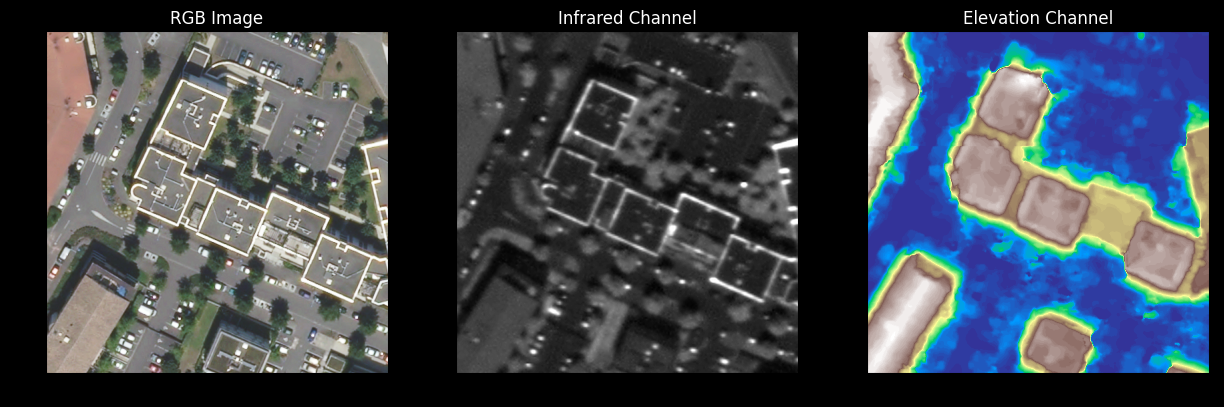

In [5]:
image=read_tif_image(tif_path)
display_5channel_image(image)

## <font color='#90c149'>NDVI Calculation and Display</font>
Then, we calculate the NDVI indice which reflects how likely a pixel is to represent vegetation in a picture. It is calculated like so :
$$NDVI = \frac{NIR - Red}{NIR + Red}$$

In [6]:
from display import display_NDVI_RGB

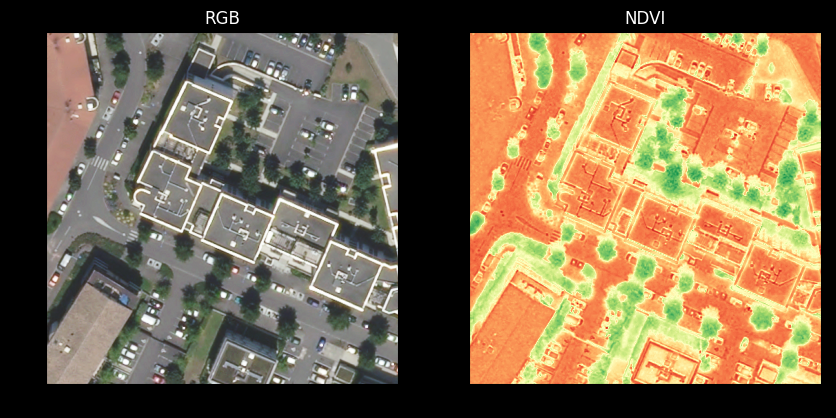

In [7]:
display_NDVI_RGB(image)

## <font color='#90c149'>Thresholds adjustement</font>
We want to remove the non-tree data of the image. In order to do so, we create a binary map from a threshold applied to the ndvi image.
$$binary(ndvi) = \begin{cases}
    1 & \text{if } ndvi>threshold \\
    0 & \text{otherwise}  \\
\end{cases}$$
We aim to set the threshold in order to see only the trees so that every tree is in a different related component in the image.

In [8]:
from processing import binary_threshold, NDVI 
from display import imshow
from ipywidgets import interact

In [9]:
image = read_tif_image(tif_path)
ndvi = NDVI(image)
@interact(minN=(-1, 1, 0.01), minE=(-1, 74, 1), maxE=(-1, 74, 1))
def threshold_and_blur(minN, minE, maxE):
    ndvi_thresholded = binary_threshold(ndvi, threshold_min=minN)
    elevation_thresholded = binary_threshold(image[:,:,4], threshold_min=minE, threshold_max=maxE)
    imshow(ndvi_thresholded, title="Only NDVI threshold")
    imshow(elevation_thresholded, title="Only elevation threshold")
    imshow(ndvi_thresholded*elevation_thresholded, title="Both thresholds")

interactive(children=(FloatSlider(value=0.0, description='minN', max=1.0, min=-1.0, step=0.01), IntSlider(valu…

We chose **minN = 0.2**, **minN = -1** and **minN = 20** and define the fonction **binary_map(image)** accordingly.

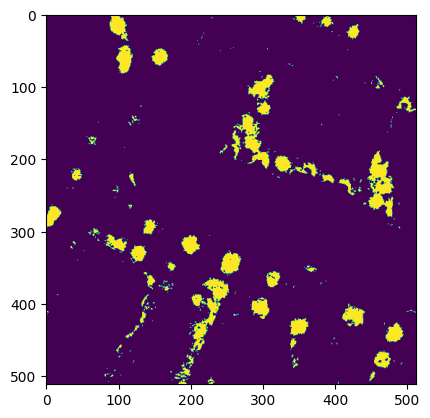

In [10]:
from processing import binary_map
imshow(binary_map(image))

We decide to keep a threshold of **0.22**

## <font color='#90c149'>Related components separation</font>


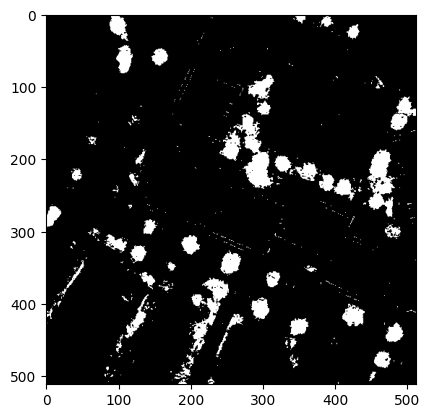

In [11]:
bw2 = np.zeros_like(ndvi)
bw2[ndvi >= 0.20] = 1
plt.imshow(bw2, cmap='gray')


image_with_ndvi_above_threshold = bw2.copy()


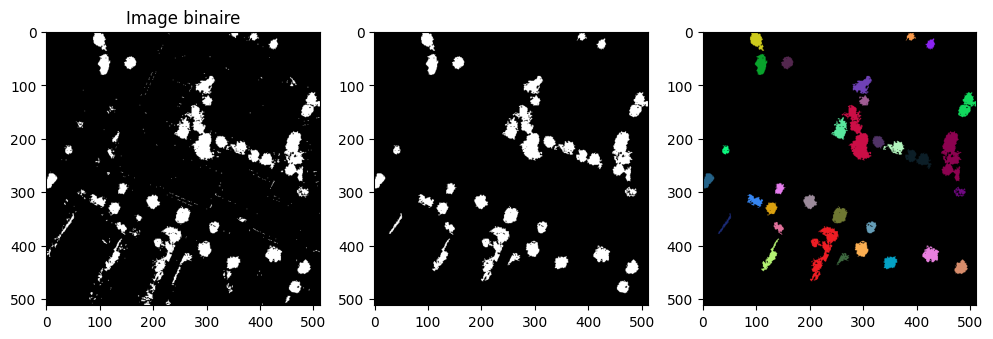

In [12]:
#take every connected component of bw2 and draw them with different colors on a new image cc, use OpenCV
import cv2

#find connected components
#convert bw2 in the right format for OpenCV
bw2 = np.uint8(bw2)
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(bw2, connectivity=8)
#what is the meaning of the parameter connectivity?

sizes = stats[1:, -1]; nb_components = nb_components - 1

# minimum size of particles we want to keep (number of pixels)
#here, it's a fixed value, but you can set it as you want, eg the mean of the sizes or whatever
min_size = 150

#your answer image
img2 = np.zeros((output.shape))
#for every component in the image, you keep it only if it's above min_size
for i in range(0, nb_components):
    if sizes[i] >= min_size:
        img2[output == i + 1] = 255


img21 = np.uint8(img2)


nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img21, connectivity=8)


colors = [np.random.randint(0, 255, 3) for _ in range(nb_components)]

# Initialiser l'image résultante avec des couleurs (img3)
img3 = np.zeros((output.shape[0], output.shape[1], 3), dtype=np.uint8)

# Pour chaque composant, attribuer une couleur unique et remplir img3
for i in range(1, nb_components-1):
    img3[output == i] = colors[i - 1]

# Afficher les images
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(bw2, cmap='gray')
plt.title('Image binaire')

plt.subplot(1, 3, 2)
plt.imshow(img2, cmap='gray')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))

plt.show()


(16, 97)
(9, 387)
(27, 429)
(76, 109)
(61, 157)
(93, 303)
(148, 487)
(133, 300)
(207, 302)
(193, 255)
(212, 457)
(207, 325)
(219, 363)
(225, 38)
(237, 409)
(277, 10)
(300, 142)
(297, 482)
(320, 94)
(320, 203)
(333, 132)
(345, 259)
(375, 30)
(365, 138)
(368, 313)
(380, 250)
(400, 133)
(411, 294)
(421, 428)
(421, 261)
(431, 350)
(445, 484)
(476, 466)


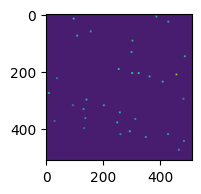

In [13]:
#prendre le max de chaque connected component et l'afficher en rouge sur une nouvelle image
# Initialiser l'image résultante en noir et blanc (img_result)
img_result = np.zeros_like(ndvi)
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img21, connectivity=8)

img_result2 = np.zeros_like(ndvi)



square_size = 3


# Pour chaque composant, extraire la région correspondante dans l'image ndvi
for i in range(1, nb_components):
    img_result2 = np.zeros_like(ndvi)
    component_mask = (output == i)
    img_result2[component_mask] = ndvi[component_mask]

    # Trouver le pixel avec la valeur maximale dans la région ndvi
    max_ndvi_pixel = np.argmax(img_result2)
    

    # Trouver les coordonnées (i, j) du pixel avec la valeur maximale dans la région
    max_ndvi_coord = np.unravel_index(max_ndvi_pixel, ndvi.shape)
    print(max_ndvi_coord)

    

    img_result[max_ndvi_coord] = ndvi[max_ndvi_coord]
    
    #display a square around the max_ndvi_coord
    for i in range(max_ndvi_coord[0] - square_size, max_ndvi_coord[0] + square_size):
        for j in range(max_ndvi_coord[1] - square_size, max_ndvi_coord[1] + square_size):
            img_result[i, j] = ndvi[i, j]




plt.subplot(1, 3, 3)
plt.imshow(img_result)

plt.show()



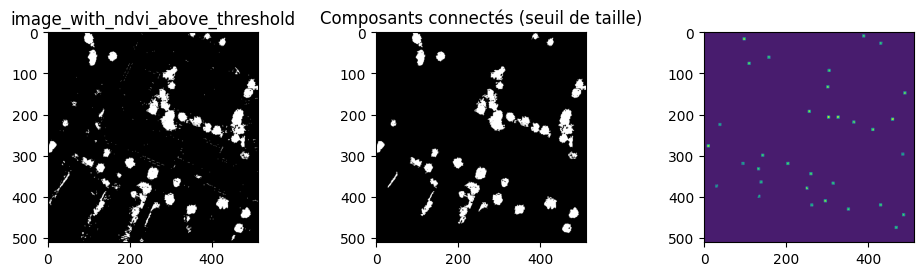

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_connected_components(image, min_size):
    # Convert the input image to the right format for OpenCV
    image = np.uint8(image)
    
    # Find connected components
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=8)
    
    # Extract sizes and update the number of components
    sizes = stats[1:, -1]
    nb_components = nb_components - 1
    
    # Initialize the answer image
    connected_components_img = np.zeros_like(image)
    
    # Keep components above the minimum size
    for i in range(nb_components):
        if sizes[i] >= min_size:
            connected_components_img[output == i + 1] = 255
    
    return connected_components_img



def colorize_connected_components(img):
    img_binary = np.uint8(img)
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img_binary, connectivity=8)

    # Generate random colors for each component
    colors = [np.random.randint(0, 255, 3) for _ in range(nb_components)]
    
    # Initialize the resulting colorized image
    colorized_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    # Assign a unique color for each component and fill the colorized image
    for i in range(1, nb_components):
        colorized_img[output == i] = colors[i - 1]
    
    return cv2.cvtColor(colorized_img, cv2.COLOR_BGR2RGB)


def highlight_max_ndvi_component(ndvi, img_filtered, square_size=3):
    # Initialiser l'image résultante en noir et blanc (img_result)
    img_result = np.zeros_like(ndvi)
    
    nb_components, output, _, _ = cv2.connectedComponentsWithStats(img_filtered, connectivity=8)

    # Parcourir chaque composant connecté
    for i in range(1, nb_components):
        # Initialiser une image pour le composant connecté courant
        img_result2 = np.zeros_like(ndvi)
        
        # Créer un masque pour le composant connecté
        component_mask = (output == i)
        
        # Remplir l'image img_result2 avec les valeurs NDVI du composant connecté
        img_result2[component_mask] = ndvi[component_mask]

        # Trouver les coordonnées (i, j) du pixel avec la valeur maximale dans le composant connecté
        max_ndvi_coord = np.unravel_index(np.argmax(img_result2), img_result2.shape)

        # Mettre à jour l'image résultante avec la valeur maximale
        img_result[max_ndvi_coord] = ndvi[max_ndvi_coord]
        
        # Afficher un carré autour des coordonnées de la valeur maximale
        for i in range(max_ndvi_coord[0] - square_size, max_ndvi_coord[0] + square_size + 1):
            for j in range(max_ndvi_coord[1] - square_size, max_ndvi_coord[1] + square_size + 1):
                img_result[i, j] = ndvi[i, j]

    return img_result




plt.figure(figsize=(12, 6))

plt.subplot(2, 3, 1)
plt.imshow(image_with_ndvi_above_threshold, cmap='gray')
plt.title('image_with_ndvi_above_threshold')

min_size = 150
connected_components_filtered = extract_connected_components(image_with_ndvi_above_threshold, min_size)

plt.subplot(2, 3, 2)
plt.imshow(connected_components_filtered, cmap='gray')
plt.title('Composants connectés (seuil de taille)')

colorized_img = colorize_connected_components(connected_components_filtered)
plt.subplot(2, 3, 3)
plt.imshow(colorized_img)



img_of_maximum = highlight_max_ndvi_component(ndvi, connected_components_filtered, square_size=3)
plt.subplot(2, 3, 3)
plt.imshow(img_of_maximum)


plt.show()


